In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geocoder
from time import sleep

In [2]:
from datetime import datetime

In [3]:
from scipy.optimize import fmin, fmin_bfgs

In [4]:
import seaborn as sns
sns.set(style="ticks", palette="Set2")

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
pwd

'/Users/mmngreco/Documents/repos/unizar/SIAD/Trabajo Grupo'

In [6]:
%matplotlib inline

# PROBLEMA 

## $\min_{x_0, y_0}{\sum{c_i · w_i · d_i}}$

## $d_i = \sqrt{(x_i - x_0)^2 + (y_i - x_0)^2}$

__DONDE:__

- $c_i$: Coste ¿unitario?.
- $w_i$: Unidades demandadas de bienes (media de los últimos 3 años)
- $d_i$: Distancia al almacén.
- $x_i$: Coordenada eje x (Longitud)
- $y_i$: Coordenada eje y (Latitud)

__Variables de decisión:__ $x_0, y_0$ 

In [7]:
def func_obj(xy0):
    'Función Obejtivo, xy0: Tupla, pares de coordenadas'
    return sum(wi * ci * di(xy0))
    

# SIMULACIÓN

## DEMANDA (CLIENTES)

### SERIE TEMPORAL TIPO:

### $y_t = \delta_0 + \delta_1 · t + u_t$

### Donde:
- $y_t$ : Ventas para cada período t.
- $\delta_0$ : Ventas indendientes o autónomas. (Stock de Seguridad pe.)
- $\delta_1$ : Pendiente la recta.
- $u_t$ : Ruido ~ N(0, 5)

En este caso para darle más realismo, $\delta_0 = \delta_a + \delta_b · sin(x)$, de esta forma introducimos un posible componente estacional, que depende cuán grande sea $\delta_b$.

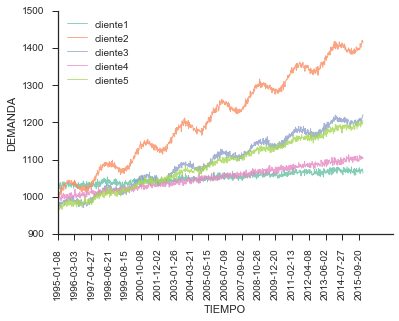

In [8]:
clientes = dict()
days_by_year = 365
nperiodos = 3 * days_by_year
tiempo = np.linspace(0 , 50, nperiodos)

for c in range(5):

    pendiente = np.random.uniform(0.5, 10)
    ruido = np.random.normal(0, 5, nperiodos)
    freq = np.random.normal(10, 10)
    demanda_a = np.random.normal(1000, 30)
    band = np.random.uniform() < 0.4
    demanda = demanda_a + (np.cos(tiempo)*band + np.sin(tiempo)*(1-band)) * freq + pendiente * tiempo + ruido
    cname = 'cliente%s' % (c+1)
    clientes[cname] = demanda

    plt.plot(demanda, alpha=0.8, label=cname, linewidth=0.91)

sns.despine()
plt.legend(loc=2)
tlabel = pd.date_range(end='2015-12-31', periods=nperiodos, freq='W')
plt.xlabel('TIEMPO')
plt.xticks(range(0, len(tiempo), 60), [t.date() for t in tlabel[0::60]], rotation=90)
plt.ylabel('DEMANDA')

In [9]:
ventas = pd.DataFrame.from_dict(clientes)

In [10]:
ventas.index = tlabel

In [11]:
ventas.head()

,cliente1,cliente2,cliente3,cliente4,cliente5
1995-01-08,1030.824806,991.368682,968.258150,995.442556,967.134352
1995-01-15,1029.951342,1002.429355,970.709391,989.607035,966.518295
1995-01-22,1028.389462,1003.981681,971.499192,998.681335,970.131538
1995-01-29,1034.340574,1006.984138,972.283993,991.875847,968.922564
1995-02-05,1032.892578,1013.716529,979.025440,998.188437,975.390552


In [12]:
path = 'Documents/repos/unizar/SIAD/Trabajo Grupo/'
data_clientes = pd.read_csv('clientes_xys.csv', index_col=0)

In [13]:
data_clientes

,prov,lat,lng
cliente1,zaragoza,41.648823,-0.889085
cliente2,oviedo,43.361915,-5.849389
cliente3,huesca,42.131845,-0.407806
cliente4,madrid,40.416775,-3.703790
cliente5,bilbao,43.263013,-2.934985


In [14]:
yi = data_clientes.lat.values
xi = data_clientes.lng.values

In [15]:
list(xi)

[-0.88908530000000008,
 -5.8493887000000004,
 -0.4078058,
 -3.7037902000000003,
 -2.9349852000000003]

## COSTES

$c_i$: Es el coste por unidad de producto vendida.

Suponemos que esta empresa ya maximiza beneficios y los precios son exógenos. Por tanto la oferta igual a la demanda, siendo ésta última estimada como la media de los últimos 3 años.

$w_i$ = $E(w_i|T)$

In [397]:
wi = ventas.mean()
ci = np.random.uniform(1, 100) + 1
di = lambda xy0: np.sqrt((xi-xy0[0]) ** 2 + (yi-xy0[1]) ** 2)

In [398]:
wi

cliente1    1051.087320
cliente2    1213.089869
cliente3    1095.379431
cliente4    1050.903511
cliente5    1085.323247
dtype: float64

# OPTIMIZACIÓN

In [399]:
res = fmin(func_obj, [0,0])

Optimization terminated successfully.
         Current function value: 667095.933771
         Iterations: 103
         Function evaluations: 196


In [400]:
res

array([ -2.58262847,  42.31881175])

# RESULTADO

Con los datos simulados, la solución óptima para el problema planteado es [ 42.23885306,  -2.5716388 ], y la función toma el valor 934296.653775.

In [401]:
fname = 'xys.csv'
file_name = 'xys_backup.csv'
file_name_new = 'pais_ca_prov_rejilla.csv'

In [402]:
muestra_xys = pd.read_csv(fname)
#muestra_xys.drop_duplicates(inplace=True)

In [403]:
muestra_xys.head()

,pais,ca,prov,lat,lng
0,PT,Viseu,Castro Daire,40.948902,-8.038607
1,PT,Viseu,Castro Daire,40.837996,-7.948673
2,PT,Viseu,Castro Daire,40.948902,-7.948673
3,PT,Viseu,Castro Daire,40.782543,-7.858738
4,PT,Viseu,Castro Daire,40.837996,-7.858738


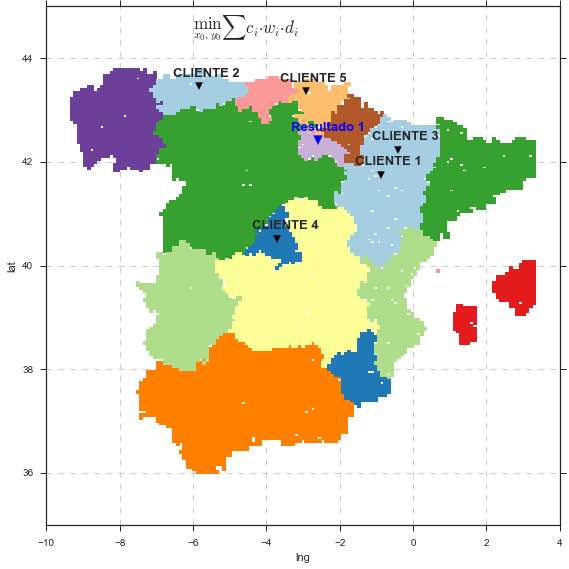

In [420]:
plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1)

color = sns.color_palette("Paired", 17)

n_color = list(map(int,'9  7 15 14 12 16 10  1  6  8 11 13  0  2  3  4  5'.split()))

# TERRITORIO
for i, region in enumerate(muestra_xys[muestra_xys.pais == 'ES'].ca.unique()):
    i = n_color[i]
    muestra_xys[muestra_xys.ca == region].plot(kind='scatter', 
                                               x='lng', 
                                               y='lat', 
                                               alpha=1, 
                                               ax=ax, 
                                               color=color[i], 
                                               marker='s',
                                               linewidths=.0,
                                              # s=80,
                                              )
# CLIENTES
for i, (y, x) in enumerate(zip(data_clientes.lat.values, data_clientes.lng.values)):

    plt.scatter(x, y*1.0025, color='black', marker='v', s=50)
    plt.text(x - 0.7,
             y + 0.3,
             'CLIENTE %s' % (i+1), weight='bold', fontsize=13)

# RESULTADO
plt.scatter(res[0], res[1]*1.0025, color='blue', marker='v', s=80)
plt.text(res[0] - 0.75, 
         res[1] + 0.3, 
         'Resultado 1',
         weight='bold',
         color='blue',
         fontsize=13)


plt.text(-6, 44.5, '$\min_{x_0,y_0}{\sum{c_i·w_i·d_i}}$', weight='bold', fontsize=17)

plt.xlim(-10,4)
ax.grid(True, linestyle='--')

plt.tight_layout()


> __NOTA:__ 
En los mapas físicos, las coordenadas están expresadas en grados, por ejemplo Puerto Rico sería: 18°14’70” N  66°29’68” W
Para convertir:
- $(18°14'70" N) = (18 + (14 / 60) + (70 / 3600)) = 18.252$
- $(66°29'68" W) = -(66 + (29 / 60) + (68 / 3600)) = -66.8627$

> La longitud se multiplica por __negativo__, porque está a la __izquierda (oeste)__ del punto 0,0.

# RESTRICCIÓN ADICIONAL

Al problema anterior, le agregamos una restricción adicional de tipo geográfica. Cada comunidad autónoma pasará a cobrar un impuesto por unidad vendida, el tipo impositivo dependerá de la comunidad autónoma, de forma que es probable que la elección óptima cambie.

Es decir:

# PROBLEMA INICIAL + RESTRICCIÓN

## $\min_{x_0, y_0}{\sum{c_i(1+t_i) · w_i · d_i}}$

__DONDE:__

- $c_i$: Coste unitario.
- $w_i$: Unidades demandadas de bienes (media de los últimos 3 años).
- $d_i$: Distancia al almacén.
- $x_i$: Coordenada eje x (Longitud).
- $y_i$: Coordenada eje y (Latitud).
- __$t_i$: Impuesto por unidad vendida.__

__Variables de decisión (Coordenadas):__ $x_0, y_0$ 


In [421]:
muestra_xys.head()

,pais,ca,prov,lat,lng
0,PT,Viseu,Castro Daire,40.948902,-8.038607
1,PT,Viseu,Castro Daire,40.837996,-7.948673
2,PT,Viseu,Castro Daire,40.948902,-7.948673
3,PT,Viseu,Castro Daire,40.782543,-7.858738
4,PT,Viseu,Castro Daire,40.837996,-7.858738


In [422]:
data_ca = muestra_xys[muestra_xys.pais == 'ES'].ca.unique()

# UNIFICAR LOS NOMBRES DE LAS CCAA

In [431]:
list(data_ca)

['GA',
 'AL',
 'CL',
 'EX',
 'Principado de Asturias',
 'Cantabria',
 'CM',
 'Comunidad de Madrid',
 'PV',
 'La Rioja',
 'Navarra',
 'Región de Murcia',
 'Aragón',
 'Comunidad Valenciana',
 'CT',
 'Valencian Community',
 'PM']

# CÓDIGO ISO PARA CCAA y PROVINCIAS

In [432]:
url = 'https://en.wikipedia.org/wiki/ISO_3166-2:ES'

# obtener códigos ISO:
ca_iso, prov_iso = pd.read_html(url, header=0, encoding='Latin')[:2]
prov_iso.columns = 'codigo nombre ca'.split()

ca_iso.drop(ca_iso.columns[-1], axis=1, inplace=True)
ca_iso.columns = 'codigo nombre'.split()

In [433]:
ca_iso

,codigo,nombre
0,ES-AN,Andalucía
1,ES-AR,Aragón
2,ES-AS,"Asturias, Principado de"
3,ES-CN,Canarias
4,ES-CB,Cantabria
5,ES-CM,Castilla La Mancha ! Castilla-La Mancha
6,ES-CL,Castilla y León
7,ES-CT,Catalunya (ca) [Cataluña]
8,ES-EX,Extremadura
9,ES-GA,Galicia (gl) [Galicia]


In [437]:
dca.split()

['Valencian', 'Community']

In [435]:
ca_iso.nombre

0                                             Andalucía
1                                                Aragón
2                               Asturias, Principado de
3                                              Canarias
4                                             Cantabria
5               Castilla La Mancha ! Castilla-La Mancha
6                                       Castilla y León
7                             Catalunya (ca) [Cataluña]
8                                           Extremadura
9                                Galicia (gl) [Galicia]
10                  Illes Balears (ca) [Islas Baleares]
11                                             La Rioja
12                                 Madrid, Comunidad de
13                                    Murcia, Región de
14    Navarra, Comunidad Foral de Nafarroako Foru Ko...
15                        País Vasco Euskal Herria (eu)
16     Valenciana, Comunidad Valenciana, Comunitat (ca)
17                                              

In [441]:
# RENOMBRAR 

rename_ca = dict()

for dca in data_ca:
    if len(dca) < 3: continue

    print(dca)
    buscar = dca.split()[-1]
    if buscar == 'Community': 
        buscar = dca.split()[0]+'a'
        
    res = ca_iso[buscar == ca_iso.nombre.apply(lambda x: list(filter(lambda y: len(y)> 2, 
                                                                     x.replace(',', '').split()))[0])]

    print(buscar, res.codigo.values[0])
    rename_ca[dca] = res.codigo.values[0][-2:]

Principado de Asturias
Asturias ES-AS
Cantabria
Cantabria ES-CB
Comunidad de Madrid
Madrid ES-MD
La Rioja
Rioja ES-RI
Navarra
Navarra ES-NC
Región de Murcia
Murcia ES-MC
Aragón
Aragón ES-AR
Comunidad Valenciana
Valenciana ES-VC
Valencian Community
Valenciana ES-VC


In [442]:
renamed = list()
for ca in muestra_xys[muestra_xys.pais == 'ES'].ca.values:
    if len(ca) < 3:
        renamed.append(ca)
    else:
        renamed.append(rename_ca[ca])
    

In [443]:
spain_xys = muestra_xys[muestra_xys.pais == 'ES']
spain_xys.loc[:, 'ca'] = renamed

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [444]:
spain_xys.ca.unique()

array(['GA', 'AL', 'CL', 'EX', 'AS', 'CB', 'CM', 'MD', 'PV', 'RI', 'NC',
       'MC', 'AR', 'VC', 'CT', 'PM'], dtype=object)

In [445]:
prov_iso.head()

,codigo,nombre,ca
0,ES-C,A Coruña (gl) [La Coruña],GA
1,ES-VI,Alava !Álava Araba (eu),PV
2,ES-AB,Albacete,CM
3,ES-A,Alicante Alacant (ca),VC
4,ES-AL,Almería,AN


In [474]:
ca_iso['name'] = ca_iso.codigo.apply(lambda x: x.split('-')[-1])

In [479]:
ti = np.random.uniform(size=19)

In [480]:
len(ca_iso)

19

In [481]:
ca_iso['ti'] = ti

In [482]:
ca_iso

,codigo,nombre,name,ti
0,ES-AN,Andalucía,AN,0.650700
1,ES-AR,Aragón,AR,0.910949
2,ES-AS,"Asturias, Principado de",AS,0.400283
3,ES-CN,Canarias,CN,0.760437
4,ES-CB,Cantabria,CB,0.774037
5,ES-CM,Castilla La Mancha ! Castilla-La Mancha,CM,0.349721
6,ES-CL,Castilla y León,CL,0.640872
7,ES-CT,Catalunya (ca) [Cataluña],CT,0.360533
8,ES-EX,Extremadura,EX,0.145848
9,ES-GA,Galicia (gl) [Galicia],GA,0.712148


In [447]:
ccaa = spain_xys.ca.unique()

In [448]:
len(ccaa)

16

In [450]:
for i,t in enumerate(ti):
    print('%s t%s\t%s' % (ccaa[i], (i+1), t))
    

GA t1	0.700496926254
AL t2	0.0315512154394
CL t3	0.279791691148
EX t4	0.0916972165369
AS t5	0.829993664998
CB t6	0.590768389968
CM t7	0.978127198464
MD t8	0.543156985046
PV t9	0.220395817352
RI t10	0.55822969899
NC t11	0.88091606083
MC t12	0.7651762687
AR t13	0.960867983337
VC t14	0.0526755558583
CT t15	0.220030935216
PM t16	0.185956119799


FALTAN DOS: CEUTA Y MELILLA

In [453]:
spain_xys.head()

,pais,ca,prov,lat,lng
87,ES,GA,Lugo,42.778861,-7.948673
88,ES,GA,Lugo,42.834314,-7.948673
89,ES,GA,Lugo,42.889767,-7.948673
90,ES,GA,Lugo,42.501594,-7.858738
91,ES,GA,Lugo,42.557048,-7.858738


In [472]:
def impuesto_ca(xy0):
    d = spain_xys.copy()
    d['dist'] = (d.lat - xy0[0]) ** 2 + (d.lng - xy0[1]) ** 2
    d['dist'] = np.sqrt(d.dist)
    return list(d[d.dist == d.dist.min()].ca)[0]

In [473]:
print(impuesto_ca([37,-5]))

AL


In [ ]:
def func_obj(xy0):
    'Función Obejtivo, xy0: Tupla, pares de coordenadas'
    return sum(wi * ci * di(xy0))


# EN R 

In [38]:
%load_ext rpy2.ipython

In [39]:
%R -o data data <- readRDS("Downloads/ESP_adm1-2.rds")


Error in gzfile(file, "rb") : no se puede abrir la conexión


/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in gzfile(file, "rb") : no se puede abrir la conexión

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: Además: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning message:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: In gzfile(file, "rb") :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/mmngreco/Virtualenvs/ip

In [40]:
%%R
plot(data[1])


Error in data[1] : objeto de tipo 'closure' no es subconjunto


/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in data[1] : objeto de tipo 'closure' no es subconjunto

  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Google Maps

![](http://www.elandroidelibre.com/wp-content/uploads/2015/06/google-maps-logo.jpg)

# MUESTREO ALEATORIO SIMPLE 
---


In [38]:
%%HTML
<iframe src="https://mapsengine.google.com/map/embed?mid=zTtXepJtMlLc.k6VXMPFTI7DI" width="740" height="480"></iframe>

In [39]:
# montecarlo
nobs = np.sqrt(20000)
xmin, xmax = -9.29769, 3.29314
ymax = 43.77702
ymin = 36.01356

xs = np.repeat(np.linspace(xmin, xmax, nobs), nobs)
ys = list(np.linspace(ymin, ymax, nobs)) * nobs
ys = np.array(ys).flatten()

/Users/mmngreco/Virtualenvs/ipynb/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [40]:
n = 11739

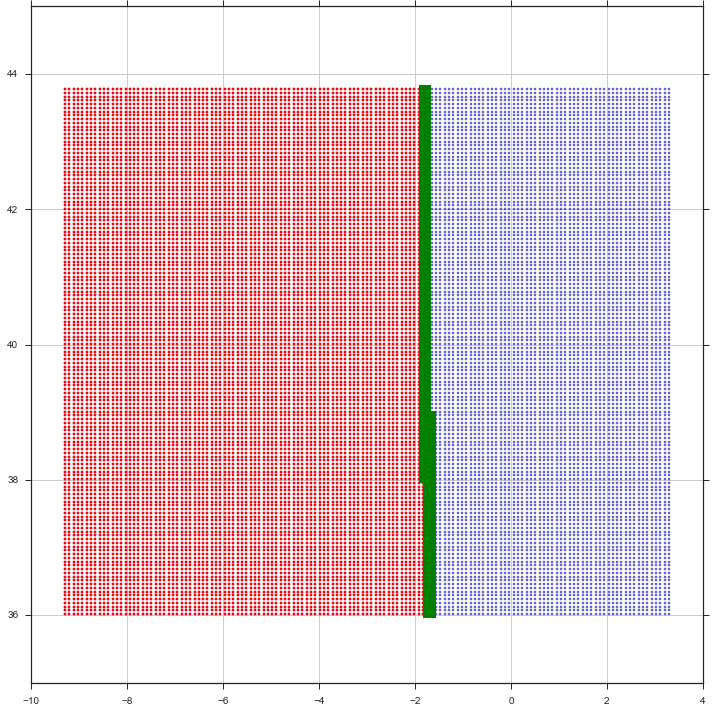

In [41]:
#n = 2500 + 2495
n = n #+ 300
nf = n + 300
plt.figure(figsize=(10,10))
plt.scatter(xs, ys, marker='.', alpha=0.6)
plt.scatter(xs[:n], ys[:n], marker='.', color='red')
plt.scatter(xs[n:nf], ys[n:nf], marker='s', color='g', s=50, linewidth=0, alpha=1)
plt.gca().grid(True)
plt.tight_layout()

# MONTECARLO

## INFORMACIÓN

In [42]:
g = geocoder.google([41.6894079, -0.8427317], method='reverse')

In [43]:
g.json

{'accuracy': 'ROOFTOP',
 'address': 'Diseminado S Gregorio el Cascajo, 9124, 50059 Zaragoza, Zaragoza, Spain',
 'bbox': {'northeast': [41.6924489802915, -0.842331019708498],
  'southwest': [41.6897510197085, -0.8450289802915021]},
 'city': 'Zaragoza',
 'confidence': 9,
 'country': 'ES',
 'county': 'Z',
 'encoding': 'utf-8',
 'housenumber': '9124',
 'lat': 41.6911,
 'lng': -0.84368,
 'location': '41.6894079, -0.8427317',
 'ok': True,
 'postal': '50059',
 'provider': 'google',
 'quality': 'street_address',
 'state': 'Aragón',
 'status': 'OK',
 'status_code': 200,
 'street': 'Diseminado S Gregorio el Cascajo'}

In [44]:
g.json['county']

'Z'

# MUESTREO

In [42]:
calls_remain = 2500

In [68]:
!open report.txt

In [43]:
# googlemaps
# from collections import defaultdict
# montecarlo = defaultdict(lambda : defaultdict(lambda : defaultdict(tuple)))

n = 19163
nf = n + 400

# MUESTREAR

In [365]:
montecarlo = dict()
ini = n
fin = nf

In [366]:
ini, fin

(10077, 10277)

In [367]:
fecha = datetime.now()

In [368]:
report = open('report.txt', 'a')

print('###################### REPORT %s ######################' % fecha, file=report)

for i, yxs in enumerate(zip(ys[ini:fin], 
                          xs[ini:fin])):

    g = geocoder.google(yxs, method='reverse')
    calls_remain -= 1
    print('.', end='')

    try:
        loc = '%s: %s: %s' % (g.json['country'], g.json['state'], g.json['county'])
        print(ini+i, end='\t')
    except:
        print('n:', ini + i,'xys:', yxs, file=report)
        sleep(.8)
        continue

    yx = [list(yxs)]
    montecarlo[loc] = montecarlo.get(loc, yx) + yx
    if calls_remain == 0: break
report.close()
print(calls_remain)

.10077	.10078	.10079	.10080	.10081	.10082	.10083	.10084	.10085	.10086	.10087	..10089	.10090	.10091	.10092	.10093	.10094	.10095	.10096	.10097	.10098	.10099	.10100	.10101	.10102	.10103	.10104	.10105	.10106	.10107	.10108	.10109	.10110	.10111	.10112	.10113	.10114	.10115	.10116	.10117	.10118	.10119	.10120	.10121	.10122	.10123	.10124	.10125	.10126	.10127	.10128	.10129	.10130	.10131	.10132	.10133	.10134	.10135	.10136	.10137	.10138	.10139	.10140	.10141	.10142	.10143	.10144	.10145	.10146	.10147	................10163	.10164	.10165	.10166	.10167	.10168	.10169	.10170	.10171	.10172	..10174	.10175	.10176	.10177	.10178	.10179	.10180	.10181	.10182	.10183	.10184	.10185	.10186	.10187	.10188	.10189	.10190	.10191	.10192	.10193	.10194	.10195	.10196	.10197	.10198	.10199	.10200	.10201	.10202	.10203	.10204	.10205	.10206	.10207	.10208	.10209	.10210	.10211	.10212	.10213	.10214	.10215	.10216	.10217	.10218	.10219	.10220	.10221	.10222	.10223	.10224	.10225	.10226	.10227	.10228	.10229	.10230	.10231	.10232	.10233	.10

# MAPA DEL MUESTREO

In [369]:
montecarlo

{'ES: AL: AL': [[36.623546142857144, -2.8224059999999991],
  [36.623546142857144, -2.8224059999999991],
  [36.67899942857143, -2.8224059999999991],
  [36.734452714285716, -2.8224059999999991],
  [36.789906000000002, -2.8224059999999991],
  [36.845359285714281, -2.8224059999999991],
  [36.900812571428567, -2.8224059999999991],
  [36.956265857142853, -2.8224059999999991],
  [37.011719142857139, -2.8224059999999991],
  [37.067172428571425, -2.8224059999999991],
  [37.122625714285711, -2.8224059999999991],
  [37.233532285714283, -2.8224059999999991]],
 'ES: AL: Granada': [[37.288985571428569, -2.8224059999999991],
  [37.288985571428569, -2.8224059999999991],
  [37.344438857142855, -2.8224059999999991],
  [37.399892142857141, -2.8224059999999991],
  [37.455345428571427, -2.8224059999999991],
  [37.510798714285713, -2.8224059999999991],
  [37.566251999999999, -2.8224059999999991],
  [37.621705285714285, -2.8224059999999991],
  [37.677158571428571, -2.8224059999999991],
  [37.732611857142857,

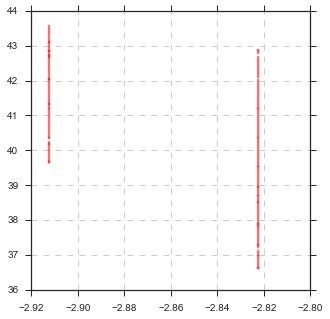

In [370]:
plt.figure(figsize=(5,5))

for k, cs in montecarlo.items():
    x = [c[0] for c in cs]
    y = [c[1] for c in cs]

    if k.startswith('ES'):
        plt.scatter(y, x, color='red', marker='.', alpha=0.5)
    else:
        plt.scatter(y, x, alpha=0.5)

plt.gca().grid(True, linestyle='--')

# ALTERNATIVA

In [371]:
mapquest_api = open('/Users/mmngreco/Documents/mq_api.txt').read()
gmaps_api = open('/Users/mmngreco/Documents/googlemaps_api.txt').read()
geocoder_api = open('/Users/mmngreco/Documents/geocoder_api.txt').read()
mbox_api = open('/Users/mmngreco/Documents/mbox_api.txt').read()

# EXPORTAR DATOS

In [372]:
fname = 'xys.csv'
f = open(fname, 'a')
for key, xys in montecarlo.items():
    for xy in xys:
        print('%s,%s,%s,%s,%s' % (*key.split(': '), *xy), file=f)

f.close()

# COMPROBAMOS LOS DATOS

In [384]:
d = pd.read_csv('xys.csv', header=0)
#d.drop_duplicates(inplace=True)

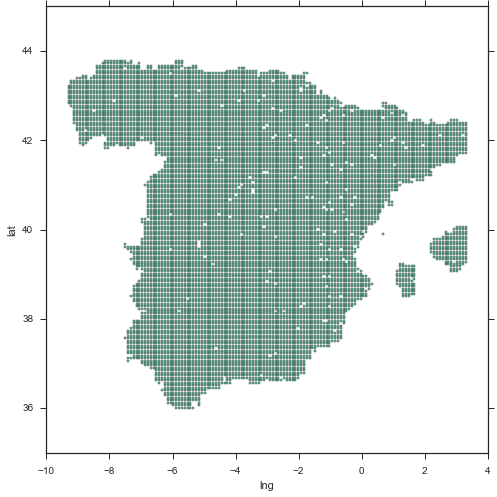

In [386]:
d[d.pais == 'ES'].plot(kind='scatter', x='lng', y='lat', marker='.', figsize=(7,7))
plt.tight_layout()

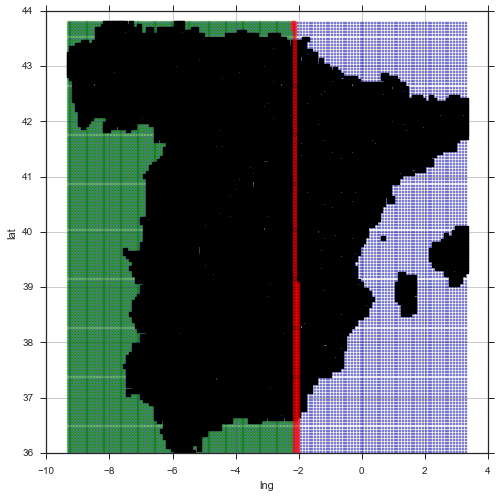

In [391]:
n -= 0
incremento = 200
n = n + incremento
nf = n + incremento

ax = plt.subplot(1,1,1)

ax.scatter(xs, ys, marker='.', alpha=0.5)
ax.scatter(xs[:n], ys[:n], marker='s', color='g', alpha=0.4)
d[d.pais == 'ES'].plot(kind='scatter', x='lng', y='lat', marker='s', figsize=(7,7), ax=ax, color='black', s=25)
ax.scatter(xs[n:nf], ys[n:nf], marker='o', color='r', s=15, linewidth=1, alpha=0.5)
ax.grid(True)

plt.ylim(36,44)
plt.xlim(-10, 4)
plt.tight_layout()

[MUESTREAR](#MUESTREAR)

AttributeError: 'list' object has no attribute 'dropna'

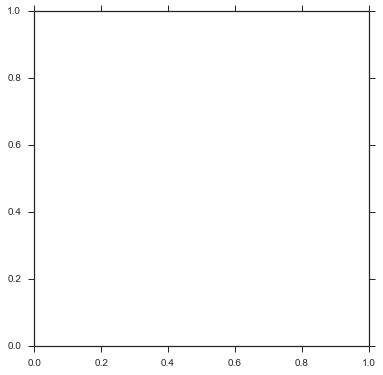

In [377]:
plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)

xys.dropna(inplace=True)
xys.drop_duplicates(inplace=True)

xys[xys.pais == 'ES'].plot(kind='scatter', x='lng', y='lat', alpha=0.7, ax=ax)

color = sns.color_palette("Set1", 17)
color = sns.color_palette("husl", len(xys[xys.pais == 'ES'].prov.unique()))
#color = sns.color_palette("cubehelix", 17)


#n_color = list(map(int,'9  7 15 14 12 16 10  1  6  8 11 13  0  2  3  4  5'.split()))

for i, region in enumerate(xys[xys.pais == 'ES'].prov.unique()):
#    i = n_color[i]
    xys[xys.prov == region].plot(kind='scatter', 
                                 x='lng', 
                                 y='lat', 
                                 alpha=0.1, 
                                 ax=ax, 
                                 color=color[i], 
                                 marker='o')

plt.xlim(-10,4)
ax.grid(True, linestyle='--')
plt.tight_layout()

In [89]:
ca_iso

,codigo,nombre
0,ES-AN,Andalucía
1,ES-AR,Aragón
2,ES-AS,"Asturias, Principado de"
3,ES-CN,Canarias
4,ES-CB,Cantabria
5,ES-CM,Castilla La Mancha ! Castilla-La Mancha
6,ES-CL,Castilla y León
7,ES-CT,Catalunya (ca) [Cataluña]
8,ES-EX,Extremadura
9,ES-GA,Galicia (gl) [Galicia]


In [82]:
prov_iso

,codigo,nombre,ca
0,ES-C,A Coruña (gl) [La Coruña],GA
1,ES-VI,Alava !Álava Araba (eu),PV
2,ES-AB,Albacete,CM
3,ES-A,Alicante Alacant (ca),VC
4,ES-AL,Almería,AN
5,ES-O,Asturias,AS
6,ES-AV,Avila !Ávila,CL
7,ES-BA,Badajoz,EX
8,ES-PM,Balears (ca) [Baleares],IB
9,ES-B,Barcelona [Barcelona],CT


https://es.wikipedia.org/wiki/F%C3%B3rmula_del_Haversine